# Reduced Helmholtz equation of state: carbon dioxide

**Water equation of state:** You can see the full, state-of-the-art equation of state for water, which also uses a reduced Helmholtz approach: the IAPWS 1995 formulation {% cite Wagner2002 %}. This equation is state is available using CoolProp with the `Water` fluid.

One modern approach for calculating thermodynamic properties of real fluids uses a reduced Helmholtz equation of state, using the reduced Helmholtz free energy function $\alpha$:
\begin{equation}
\alpha (\tau, \delta) = \frac{a}{RT} = \frac{u - Ts}{RT}
\end{equation}
which is a function of reduced density $\delta$ and reduced temperature $\tau$:
\begin{equation}
\delta = \frac{\rho}{\rho_{\text{crit}}} \quad \text{and} \quad \tau = \frac{T_{\text{crit}}}{T}
\end{equation}

The reduced Helmhotz free energy function, $\alpha(\tau, \delta)$, is given as the sum of ideal gas and residual components:
\begin{equation}
\alpha(\tau, \delta) = \alpha_{IG} (\tau, \delta) + \alpha_{\text{res}} (\tau, \delta) \;,
\end{equation}
which are both given as high-order fits using many coefficients:

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# these are mostly for making the saved figures nicer
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi']= 150
plt.rcParams['savefig.dpi'] = 150

import numpy as np
import cantera as ct
from scipy import integrate, optimize

from pint import UnitRegistry
ureg = UnitRegistry()
Q_ = ureg.Quantity

In [3]:
import sympy
sympy.init_printing(use_latex='mathjax')

T, R, tau, delta = sympy.symbols('T, R, tau, delta', real=True)

a_vars = sympy.symbols('a0, a1, a2, a3, a4, a5, a6, a7', real=True)
theta_vars = sympy.symbols('theta3, theta4, theta5, theta6, theta7', real=True)
n_vars = sympy.symbols('n0, n1, n2, n3, n4, n5, n6, n7, n8, n9, n10, n11', real=True)

alpha_ideal = sympy.log(delta) + a_vars[0] + a_vars[1]*tau + a_vars[2]*sympy.log(tau)
for i in range(3, 8):
    alpha_ideal += a_vars[i] * sympy.log(1.0 - sympy.exp(-tau * theta_vars[i-3]))
display(sympy.Eq(sympy.symbols('alpha_IG'), alpha_ideal))

alpha_res = (
    n_vars[0] * delta * tau**0.25 + 
    n_vars[1] * delta * tau**1.25 + 
    n_vars[2] * delta * tau**1.50 + 
    n_vars[3] * delta**3 * tau**0.25 + 
    n_vars[4] * delta**7 * tau**0.875 + 
    n_vars[5] * delta * tau**2.375 * sympy.exp(-delta) + 
    n_vars[6] * delta**2 * tau**2 * sympy.exp(-delta) + 
    n_vars[7] * delta**5 * tau**2.125 * sympy.exp(-delta) +
    n_vars[8] * delta * tau**3.5 * sympy.exp(-delta**2) + 
    n_vars[9] * delta * tau**6.5 * sympy.exp(-delta**2) + 
    n_vars[10] * delta**4 * tau**4.75 * sympy.exp(-delta**2) + 
    n_vars[11] * delta**2 * tau**12.5 * sympy.exp(-delta**3)
    )
display(sympy.Eq(sympy.symbols('alpha_res'), alpha_res))

                                     ⎛       -τ⋅θ₃⎞         ⎛       -τ⋅θ₄⎞    
α_IG = a₀ + a₁⋅τ + a₂⋅log(τ) + a₃⋅log⎝1.0 - ℯ     ⎠ + a₄⋅log⎝1.0 - ℯ     ⎠ + a

     ⎛       -τ⋅θ₅⎞         ⎛       -τ⋅θ₆⎞         ⎛       -τ⋅θ₇⎞         
₅⋅log⎝1.0 - ℯ     ⎠ + a₆⋅log⎝1.0 - ℯ     ⎠ + a₇⋅log⎝1.0 - ℯ     ⎠ + log(δ)

                                                         2                    
        7     0.875    5     2.125  -δ    4      4.75  -δ     3     0.25    2 
αᵣₑₛ = δ ⋅n₄⋅τ      + δ ⋅n₇⋅τ     ⋅ℯ   + δ ⋅n₁₀⋅τ    ⋅ℯ    + δ ⋅n₃⋅τ     + δ ⋅

             3                                                                
     12.5  -δ     2     2  -δ         0.25         1.25         1.5         2.
n₁₁⋅τ    ⋅ℯ    + δ ⋅n₆⋅τ ⋅ℯ   + δ⋅n₀⋅τ     + δ⋅n₁⋅τ     + δ⋅n₂⋅τ    + δ⋅n₅⋅τ  

                       2                2
375  -δ         3.5  -δ          6.5  -δ 
   ⋅ℯ   + δ⋅n₈⋅τ   ⋅ℯ    + δ⋅n₉⋅τ   ⋅ℯ   

## Carbon dioxide equation of state

The coefficients $a_i$, $\theta_i$, and $n_i$ are given for carbon dioxide:

In [4]:
# actual coefficients
coeffs_a = [
    8.37304456, -3.70454304, 2.500000, 1.99427042, 
    0.62105248, 0.41195293, 1.04028922, 8.327678e-2
    ]
coeffs_theta = [
    3.151630, 6.111900, 6.777080, 11.32384, 27.08792
    ]
coeffs_n = [
    0.89875108, -0.21281985e1, -0.68190320e-1, 0.76355306e-1,
    0.22053253e-3, 0.41541823, 0.71335657, 0.30354234e-3,
    -0.36643143, -0.14407781e-2, -0.89166707e-1, -0.23699887e-1
    ]

Through some math, we can find an expression for pressure:
\begin{equation}
P = R T \rho \left[ 1 + \delta \left(\frac{\partial \alpha_{\text{res}}}{\partial \delta} \right)_{\tau} \right]
\end{equation}

Use this expression to estimate the pressure at $T$ = 350 K and $v$ = 0.01 m$^3$/kg, and compare against that obtained from Cantera. We can use our symbolic expression for $\alpha_{\text{res}} (\tau, \delta)$ and take the partial derivative:

In [5]:
# use Cantera fluid to get specific gas constant and critical properties
f = ct.CarbonDioxide()
gas_constant = ct.gas_constant / f.mean_molecular_weight
temp_crit = f.critical_temperature
density_crit = f.critical_density

# conditions of interest
temp = 350
specific_volume = 0.01
density = 1.0 / specific_volume

# take the partial derivative of alpha_res with respect to delta
derivative_alpha_delta = sympy.diff(alpha_res, delta)

# substitute all coefficients
derivative_alpha_delta = derivative_alpha_delta.subs(
    [(n, n_val) for n, n_val in zip(n_vars, coeffs_n)]
    )

def get_pressure(
    temp, specific_vol, fluid, derivative_alpha_delta, tau, delta
    ):
    '''Calculates pressure for reduced Helmholtz equation of state'''
    red_density = (1.0 / specific_vol) / fluid.critical_density
    red_temp_inv = fluid.critical_temperature / temp

    gas_constant = ct.gas_constant / fluid.mean_molecular_weight
    
    dalpha_ddelta = derivative_alpha_delta.subs(
        [(delta, red_density), (tau, red_temp_inv)]
        )
    
    pres = (
        gas_constant * temp * (1.0 / specific_vol) * 
        (1.0 + red_density * dalpha_ddelta)
        )
    return pres

pres = get_pressure(temp, specific_volume, f, derivative_alpha_delta, tau, delta)

print(f'Pressure: {pres / 1e6: .3f} MPa')

f.TV = temp, specific_volume
print(f'Cantera pressure: {f.P / 1e6: .3f} MPa')

Pressure:  5.464 MPa
Cantera pressure:  5.475 MPa


Our calculation and that from Cantera agree fairly well! They are not exactly the same because Cantera uses a slightly different formulation for the equation of state.

Let's compare the calculations now for a range of specific volumes and multiple temperatures:

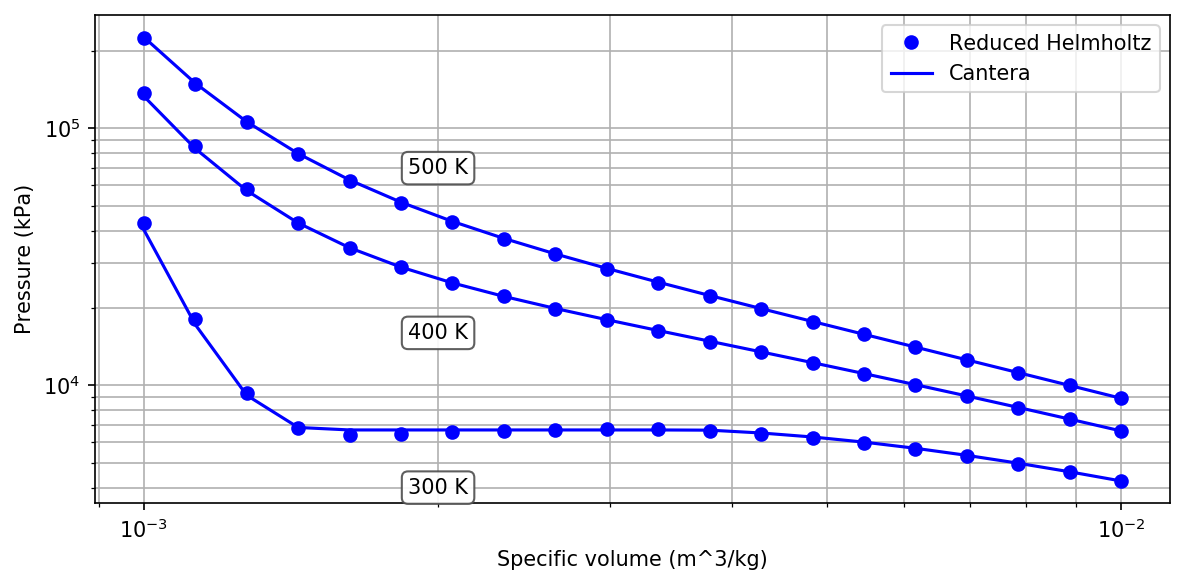

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

specific_volumes = np.geomspace(0.001, 0.01, num=20)
temperatures = [300, 400, 500]

for temp in temperatures:
    pressures = np.zeros(len(specific_volumes))
    pressures_cantera = np.zeros(len(specific_volumes))
    
    for idx, spec_vol in enumerate(specific_volumes):
        pressures[idx] = get_pressure(
            temp, spec_vol, f, 
            derivative_alpha_delta, tau, delta
            )
        
        f.TV = temp, spec_vol
        pressures_cantera[idx] = f.P
    
    ax.loglog(specific_volumes, pressures/1000., 'o', color='blue')
    ax.loglog(specific_volumes, pressures_cantera/1000., color='blue')

bbox_props = dict(boxstyle='round', fc='w', ec='0.3', alpha=0.9)
ax.text(2e-3, 4e3, '300 K', ha='center', va='center', bbox=bbox_props)
ax.text(2e-3, 1.6e4, '400 K', ha='center', va='center', bbox=bbox_props)
ax.text(2e-3, 7e4, '500 K', ha='center', va='center', bbox=bbox_props)

ax.legend(['Reduced Helmholtz', 'Cantera'])
plt.grid(True, which='both')
plt.xlabel('Specific volume (m^3/kg)')
plt.ylabel('Pressure (kPa)')
fig.tight_layout()
plt.show()

We can see that the pressure calculated using the reduced Helmholtz equation of state matches closely with that from Cantera, which uses a different but similarly advanced equation of state.

## Bibliography

{% bibliography --cited %}